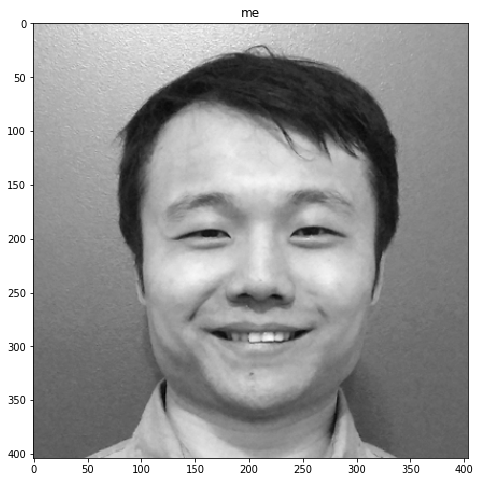

In [274]:
import cv2
from sklearn.preprocessing import StandardScaler
import numpy as np

PAD_SIZE = 10

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def pad_3d(img_3d, length):
    c, h, w = img_3d.shape
    assert(c <= 4)
    img_3d = np.pad(img_3d, ((0,0), (length, length), (0, 0)), 'constant', constant_values=0)
    return np.pad(img_3d, ((0,0), (0, 0), (length, length)), 'constant', constant_values=0)

def depad_3d(img_3d, length):
    c, h, w = img_3d.shape
    im = img_3d
    im = im[0, length:h - length, length: w - length]
    im = cv2.resize(im, dsize=(h, w))
    im = np.expand_dims(im, axis=0)
    return im

def normalize(img):
    return (im - im.mean()) / im.std() / 0.5
def load_image(path):
    im = cv2.imread(path)
    im = rgb2gray(im)
    # im = np.rollaxis(im, 2, 0)
    im = cv2.resize(im, dsize=(384, 384))
    im = np.expand_dims(im, axis=0)
    im = im.astype('float32')
    # im = (im - 0.5) / 0.5
    # im = (im - 0.5) / 0.5
    # im = StandardScaler().fit_transform(im) * 2
#     print(im.std())
    return im

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def display_image(im):
    fig = plt.figure(figsize = (8,8)) # create a 5 x 5 figure 
    ax3 = fig.add_subplot(111)
    ax3.imshow(im[0,:,:], cmap="gray", interpolation='none')
    ax3.set_title('me')
    plt.show()


im = load_image("test_photos/xiyang.jpg")
im = pad_3d(im, PAD_SIZE)
im = normalize(im)
# print(depad_3d(pad_3d(im, PAD_SIZE), PAD_SIZE).shape)
display_image(depad_3d(im, PAD_SIZE))

In [275]:
from models import create_model
from models.networks import define_G
import os
import torch


def load_model(epoch_id):
    gpu_ids = None
    net = define_G(1, 1, 64, 'resnet_9blocks', 'instance', False, 'normal', 0.02, [])
    load_filename = f'{epoch_id}_net_G_B.pth'
    load_path = os.path.join('./checkpoints/face2sketch_combine_attempt_2', load_filename)
    if isinstance(net, torch.nn.DataParallel):
        net = net.module
    print('loading the model from %s' % load_path)
    device = torch.device('cuda:{}'.format(gpu_ids[0])) if gpu_ids else torch.device('cpu')
    state_dict = torch.load(load_path, map_location=str(device))
    if hasattr(state_dict, '_metadata'):
        del state_dict._metadata
    net.load_state_dict(state_dict)
    return net

initialize network with normal
loading the model from ./checkpoints/face2sketch_combine_attempt_2/latest_net_G_B.pth


/Users/settinghead/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/Users/settinghead/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


--- 12.097688913345337 seconds ---


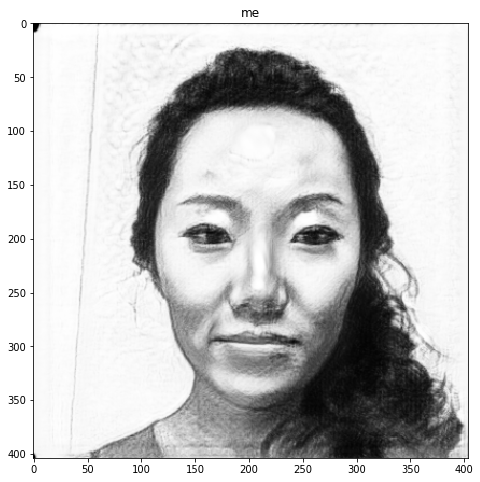

In [285]:
import time
net = load_model("latest")
im = load_image("test_photos/mengqi6.jpg")
im = pad_3d(im, PAD_SIZE)
# im = normalize(im)
im_t = torch.from_numpy(np.expand_dims(im, axis=0))
start_time = time.time()
output = net(im_t)
print("--- %s seconds ---" % (time.time() - start_time))
result = output.cpu().data.numpy()[0]
result = depad_3d(result, PAD_SIZE)
display_image(result)

In [ ]:
import cv2, numpy as np, os
import face_recognition
cap = cv2.VideoCapture(0)

org, font, scale, color, thickness, linetype = (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (234,12,123), 2, cv2.LINE_AA

while True:
    _, img = cap.read()
    if img.shape:
        locs = face_recognition.face_locations(img, model='hog')
        if len(locs) > 0:
            top, right, bottom, left = locs[0]
#             cv2.line(img, (a, ), (310,240), (234,123,234), 3)
#             cv2.line(img, (320,250), (320,230), (234,123,234), 3)
            pad_v = (top - bottom) // 5 
            pad_h = (right - left) // 1.8
            try:
                img = img[int(top - pad_h):int(bottom + pad_h), int(left + pad_v):int(right - pad_v)]
            except:
                pass
#             cv2.putText(
#                 img, "%d, %d, %d, %d" % (y,x,h,w),
#                 org, font, scale, color, thickness, linetype
#             )
#         img_data = img_data.astype('float32')
#         img_data = preprocessor(img_data)
#         y = model.predict(img_data)[0]
#         cls = np.argmax(y)
#         prob = y[cls]
#         if(prob > 0.5):
#             cv2.putText(
#                 img, 'Class: ' + text_labels[cls] + ' Prob: ' + str(prob), 
#                 org, font, scale, color, thickness, linetype)
#         cv2.line(img, (330,240), (310,240), (234,123,234), 3)
#         cv2.line(img, (320,250), (320,230), (234,123,234), 3)
        cv2.imshow('img', img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            cap.release()
            cv2.destroyAllWindows()